Initial image count: 2167
Checking 2167 images for corruption...
Final image count: 2167
Classes: ['closedFist', 'fingerCircle', 'fingerSymbols', 'multiFingerBend', 'openPalm', 'semiOpenFist', 'semiOpenPalm', 'singleFingerBend']
Number of classes: 8


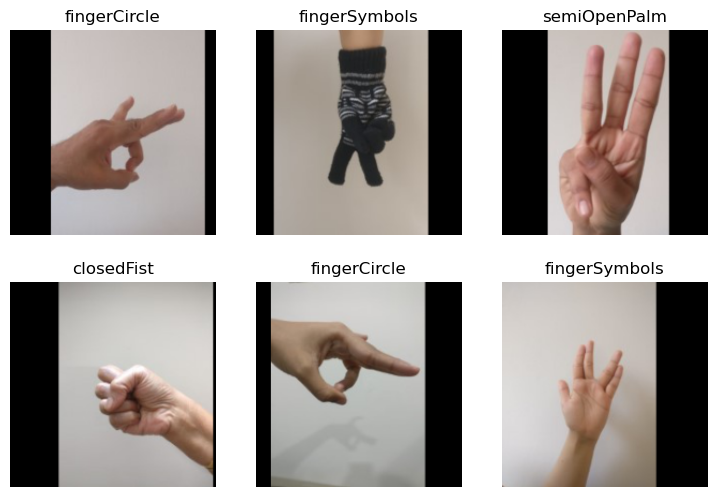

Image mode: RGB


epoch,train_loss,valid_loss,error_rate,time
0,2.826167,1.750403,0.558891,00:06


epoch,train_loss,valid_loss,error_rate,time
0,1.952861,1.440798,0.468822,00:07
1,1.519938,1.237589,0.413395,00:07
2,1.130709,1.034595,0.341801,00:07
3,0.839716,0.908324,0.297921,00:07
4,0.667397,0.912775,0.290993,00:07


Prediction: fingerCircle
Confidence: 0.9214


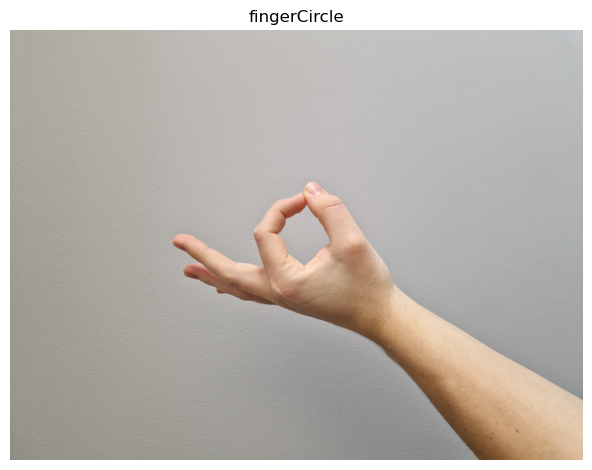

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from fastai.vision.all import *
from PIL import Image
from fastai.vision.utils import show_image

# Clear any cached GPU memory
torch.cuda.empty_cache()

# Remove corrupt or non-finite images
def clean_images(img_paths):
    for img_path in img_paths:
        try:
            img = PILImage.create(img_path)
            tensor = ToTensor()(img)
            if not torch.isfinite(tensor).all():
                print(f"Bad tensor: {img_path}")
                img_path.unlink()
        except Exception as e:
            print(f"Corrupt image: {img_path}, Error: {e}")
            img_path.unlink()

def main():
    path = Path('hand_gestures/images')
    
    print("Initial image count:", len(get_image_files(path)))
    
    # Clean up images
    all_imgs = get_image_files(path)
    print(f"Checking {len(all_imgs)} images for corruption...")
    clean_images(all_imgs)
    print("Final image count:", len(get_image_files(path)))

    # Create DataLoaders
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock), 
        get_items=get_image_files, 
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        item_tfms=[Resize(192, method='pad', pad_mode='zeros')]
    )
    dls = dblock.dataloaders(path, bs=32)

    print("Classes:", dls.vocab)
    print("Number of classes:", dls.c)

    # Show batch
    dls.show_batch(max_n=6)
    plt.show()

    # Display image mode
    test_img_path = 'do_rozpoznania/20250406_135604.jpg'
    test_img = PILImage.create(test_img_path)
    print("Image mode:", test_img.mode)

    # Train model
    learn = vision_learner(dls, resnet18, metrics=error_rate)
    learn.lr_find()
    learn.fine_tune(5, base_lr=1e-3)

    # Prediction
    pred_label, _, probs = learn.predict(PILImage.create(test_img_path))
    print(f"Prediction: {pred_label}")
    print(f"Confidence: {probs.max():.4f}")

    # Show predicted image with label
    img = mpimg.imread(test_img_path)
    plt.close('all')  # Clear previous plots, esp. from lr_find()
    plt.imshow(img)
    plt.title(pred_label)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

Prediction: semiOpenFist
Confidence: 0.5910


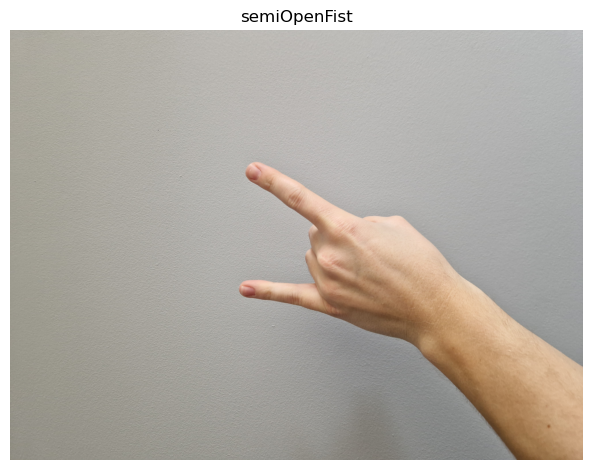

In [19]:
test_img_path = 'do_rozpoznania/20250406_135614.jpg'
test_img = PILImage.create(test_img_path)

pred_label, _, probs = learn.predict(PILImage.create(test_img_path))
print(f"Prediction: {pred_label}")
print(f"Confidence: {probs.max():.4f}")

# Show predicted image with label
img = mpimg.imread(test_img_path)
plt.close('all')  # Clear previous plots, esp. from lr_find()
plt.imshow(img)
plt.title(pred_label)
plt.axis('off')
plt.tight_layout()
plt.show()

Prediction: openPalm
Confidence: 0.5437


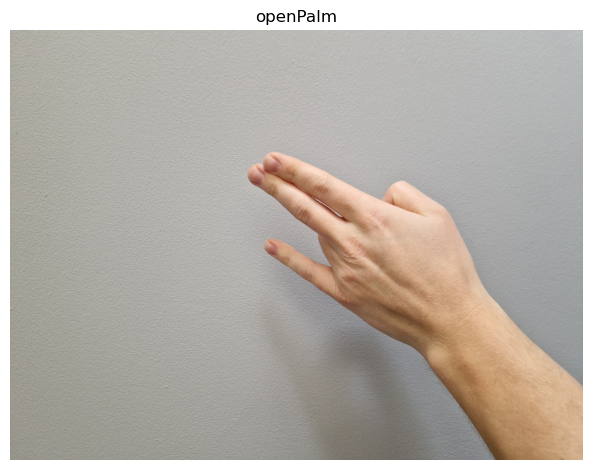

In [20]:
test_img_path = 'do_rozpoznania/20250406_135846.jpg'
test_img = PILImage.create(test_img_path)

pred_label, _, probs = learn.predict(PILImage.create(test_img_path))
print(f"Prediction: {pred_label}")
print(f"Confidence: {probs.max():.4f}")

# Show predicted image with label
img = mpimg.imread(test_img_path)
plt.close('all')  # Clear previous plots, esp. from lr_find()
plt.imshow(img)
plt.title(pred_label)
plt.axis('off')
plt.tight_layout()
plt.show()